In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

from dask.distributed import Client
#client = Client(n_workers=5, threads_per_worker=1,
#                memory_limit="24G",
#                dashboard_address="localhost:8787")

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44443 instead
  warnings.warn(


In [13]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%%time

#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 1min 2s, sys: 7.88 s, total: 1min 10s
Wall time: 1min 4s


In [6]:
%%time
# load pre-saved FG sample
_sample_hips = lsdb.read_hipscat("/astro/users/atzanida/epyc/ssd/users/atzanida/tmp/data_files/fg_sample")

CPU times: user 2.83 s, sys: 107 ms, total: 2.94 s
Wall time: 2.61 s


,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,parallax_error_gaia,phot_g_mean_mag_gaia,l_gaia,b_gaia,non_single_star_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,in_qso_candidates_gaia,teff_gspphot_gaia,teff_gspphot_upper_gaia,teff_gspphot_lower_gaia,logg_gspphot_gaia,logg_gspphot_lower_gaia,logg_gspphot_upper_gaia,mh_gspphot_gaia,mh_gspphot_lower_gaia,mh_gspphot_upper_gaia,distance_gspphot_gaia,distance_gspphot_lower_gaia,distance_gspphot_upper_gaia,azero_gspphot_gaia,azero_gspphot_lower_gaia,azero_gspphot_upper_gaia,ag_gspphot_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,Norder_gaia,Npix_gaia,Dir_gaia,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix
npartitions=7037,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64
1125899906842624,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13832806255468478464,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 33s, sys: 6.05 s, total: 1min 39s
Wall time: 1min 30s


In [22]:
_sources

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,pmdec_error_gaia_andy_fg_dwarfs,parallax_error_gaia_andy_fg_dwarfs,phot_g_mean_mag_gaia_andy_fg_dwarfs,l_gaia_andy_fg_dwarfs,b_gaia_andy_fg_dwarfs,non_single_star_gaia_andy_fg_dwarfs,classprob_dsc_combmod_galaxy_gaia_andy_fg_dwarfs,classprob_dsc_combmod_star_gaia_andy_fg_dwarfs,in_qso_candidates_gaia_andy_fg_dwarfs,teff_gspphot_gaia_andy_fg_dwarfs,teff_gspphot_upper_gaia_andy_fg_dwarfs,teff_gspphot_lower_gaia_andy_fg_dwarfs,logg_gspphot_gaia_andy_fg_dwarfs,logg_gspphot_lower_gaia_andy_fg_dwarfs,logg_gspphot_upper_gaia_andy_fg_dwarfs,mh_gspphot_gaia_andy_fg_dwarfs,mh_gspphot_lower_gaia_andy_fg_dwarfs,mh_gspphot_upper_gaia_andy_fg_dwarfs,distance_gspphot_gaia_andy_fg_dwarfs,distance_gspphot_lower_gaia_andy_fg_dwarfs,distance_gspphot_upper_gaia_andy_fg_dwarfs,azero_gspphot_gaia_andy_fg_dwarfs,azero_gspphot_lower_gaia_andy_fg_dwarfs,azero_gspphot_upper_gaia_andy_fg_dwarfs,ag_gspphot_gaia_andy_fg_dwarfs,ebpminrp_gspphot_gaia_andy_fg_dwarfs,ebpminrp_gspphot_lower_gaia_andy_fg_dwarfs,ebpminrp_gspphot_upper_gaia_andy_fg_dwarfs,Norder_gaia_andy_fg_dwarfs,Npix_gaia_andy_fg_dwarfs,Dir_gaia_andy_fg_dwarfs,ps1_objid_ztf_dr14_andy_fg_dwarfs,ra_ztf_dr14_andy_fg_dwarfs,dec_ztf_dr14_andy_fg_dwarfs,ps1_gMeanPSFMag_ztf_dr14_andy_fg_dwarfs,ps1_rMeanPSFMag_ztf_dr14_andy_fg_dwarfs,ps1_iMeanPSFMag_ztf_dr14_andy_fg_dwarfs,nobs_g_ztf_dr14_andy_fg_dwarfs,nobs_r_ztf_dr14_andy_fg_dwarfs,nobs_i_ztf_dr14_andy_fg_dwarfs,mean_mag_g_ztf_dr14_andy_fg_dwarfs,mean_mag_r_ztf_dr14_andy_fg_dwarfs,mean_mag_i_ztf_dr14_andy_fg_dwarfs,Norder_ztf_dr14_andy_fg_dwarfs,Dir_ztf_dr14_andy_fg_dwarfs,Npix_ztf_dr14_andy_fg_dwarfs,_DIST_andy_fg_dwarfs,Norder_andy_fg_dwarfs,Dir_andy_fg_dwarfs,Npix_andy_fg_dwarfs,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
npartitions=287241,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## TAPE

In [15]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(n_workers=5, threads_per_worker=1, memory_limit="24G")
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33820 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33820/status,
Dashboard: http://127.0.0.1:33820/status,Workers: 5
Total threads: 5,Total memory: 111.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44036,Workers: 5
Dashboard: http://127.0.0.1:33820/status,Total threads: 5
Started: Just now,Total memory: 111.76 GiB
Comm: tcp://127.0.0.1:38405,Total threads: 1
Dashboard: http://127.0.0.1:33670/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:39732,


In [16]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Test Case gr combined

In [128]:
%%time
# know dipper
# working example 4078931319013244928
# good example: 16721355873452032

lc = ens.source.loc[391062914590572544]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 15.9 s, sys: 1.65 s, total: 17.6 s
Wall time: 18 s


In [135]:
lc.head(1)

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
391062914590572544,84.116859,43.405593,0.439898,10.388184,0.846287,1636148068921376768,195531448466897408,-0.046876,0.055548,-3.884604,...,-32768,704,18.87701,0.050354,58440.42119,61,g,8,20000,22229


In [129]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='g', flag_good=0)

(19.145585345849394, 15.457600017264486)

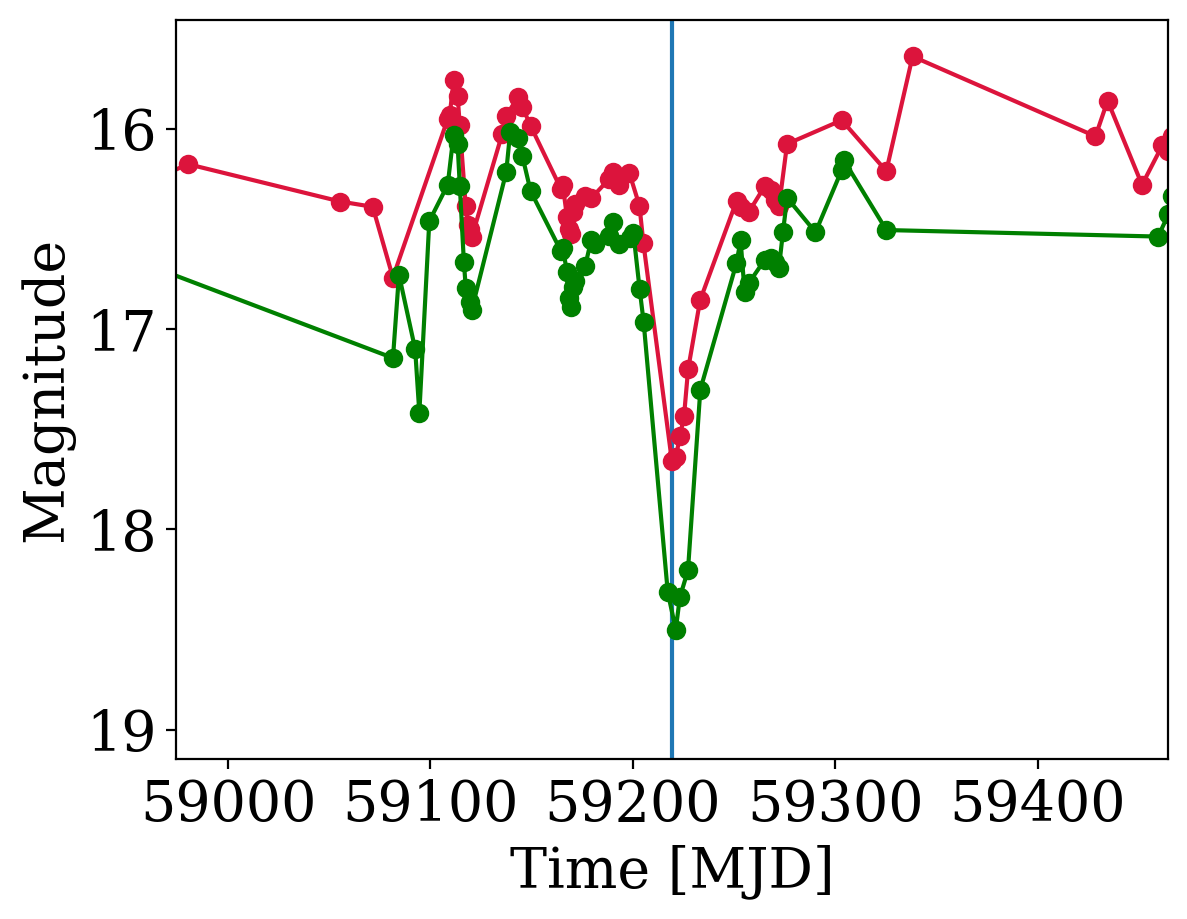

In [133]:
plt.errorbar(time, mag, magerr, fmt='-o', color='Crimson')
plt.errorbar(timeg, magg, magerrg, fmt='-o', color='green')

loc = 59219.26408

plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude")

plt.axvline(loc)
plt.xlim(loc-245, loc+245)

plt.ylim(plt.ylim()[::-1])

Text(0, 0.5, 'Normalized Mag')

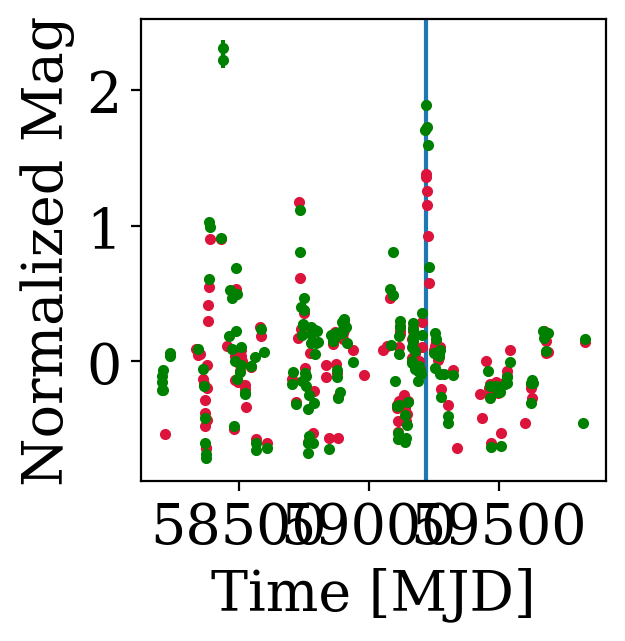

In [134]:
plt.figure(figsize=(3,3))
plt.errorbar(time, mag-np.median(mag), magerr, fmt='.', color='Crimson')
plt.errorbar(timeg, magg-np.median(magg), magerrg, fmt='.', color='green')
plt.axvline(loc)
plt.xlabel("Time [MJD]")
plt.ylabel("Normalized Mag")

In [16]:
# test should be nan because it's *not* a real dipper.
print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

Nphot                         2.400000e+02
biweight_scale                3.461178e-02
frac_above_2_sigma            4.166667e-02
Ndips                         1.000000e+00
rate                          6.132517e-04
chi2dof                       1.014158e+00
ADF_const                    -4.624648e-01
ADF_const_trend              -2.798006e+00
ADF_pval_const                8.991355e-01
ADF_pval_const_trend          1.976778e-01
skew                          9.245210e-01
kurtosis                      1.285840e+00
mad                           2.228355e-02
stetson_i                     1.064999e+03
stetson_j                     2.662099e+02
stetson_k                     7.631465e-01
invNeumann                    1.687574e+00
best_dip_power                3.844841e+00
best_dip_time_loc             5.980731e+04
best_dip_start                5.980121e+04
best_dip_end                  5.981320e+04
best_dip_dt                   0.000000e+00
best_dip_ndet                 4.000000e+00
best_dip_sc

## Full Search

In [17]:
# define my cols 
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'rate',
    'chi2dof',
    'ADF_const',
    'ADF_const_trend',
    'ADF_pval_const',
    'ADF_pval_const_trend',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_score',
    'left_error',
    'right_error',
    'chi_square_gp',
    'gp_fun',
    'gp_status',
    'separation_btw_peaks',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2']

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [18]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate,
    'mjd_ztf_source', 'mag_ztf_source', 
    'magerr_ztf_source', 'catflags_ztf_source',
    'band_ztf_source', 'ra_ztf_source', 
    'dec_ztf_source',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 392 ms, sys: 34.7 ms, total: 426 ms
Wall time: 420 ms


In [19]:
%%time
ens.object.join(calc_).update_ensemble()

CPU times: user 9.7 s, sys: 903 ms, total: 10.6 s
Wall time: 10.2 s


In [49]:
%%time
demo_table = ens.object.head(150_000, npartitions=5_000)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 19.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:8260: UserWarning: Insufficient elements for `head`. 150000 elements requested, only 124440 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


CPU times: user 10min 23s, sys: 1min 36s, total: 12min
Wall time: 24min 58s


In [126]:
q = (demo_table['best_dip_power']>3) & (demo_table['best_dip_ndet']>4)

In [127]:
demo_table[q]['best_dip_time_loc']

_hipscat_index
214833630155898880    58370.41837
391062914590572544    59219.26408
393852297223864320    58875.21997
393891728140009472    58882.14278
394162237763223552    58376.51078
Name: best_dip_time_loc, dtype: float64

True
